In [ ]:
import pandas as pd
import os
print(os.getcwd())
print(os.listdir())
import json

In [ ]:
with open('train.json', 'r') as f:
    data = json.load(f)
df = pd.DataFrame(data)

In [ ]:
df.isnull().sum()
df.cuisine.value_counts()

In [ ]:
import matplotlib.pylab as plt
df.cuisine.value_counts().plot.bar()
plt.show()

In [266]:
df['cuisine_id'] = df['cuisine'].factorize()[0]
cuisine_id_df = df[['cuisine', 'cuisine_id']].drop_duplicates().sort_values('cuisine_id')
cuisine_to_id = dict(cuisine_id_df.values)
id_to_cuisine = dict(cuisine_id_df[['cuisine_id', 'cuisine']].values)

In [267]:
df['ingredients2'] = df['ingredients'].apply(lambda x: ' '.join(x))
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.ingredients2).toarray()
labels = df.cuisine_id

In [274]:
from sklearn.feature_selection import chi2
import numpy as np
N = 4
cuisine_list=[] #list of all cuisine names
com_unigram_list=[] #list of most correlated ingredients of each cuisine
for cuisine, cuisine_id in sorted(cuisine_to_id.items()):
    features_chi2 = chi2(features, labels == cuisine_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    #bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    cuisine_list.append(cuisine)
    com_unigram_list.append(unigrams[-N:])

In [276]:
from wordcloud import WordCloud

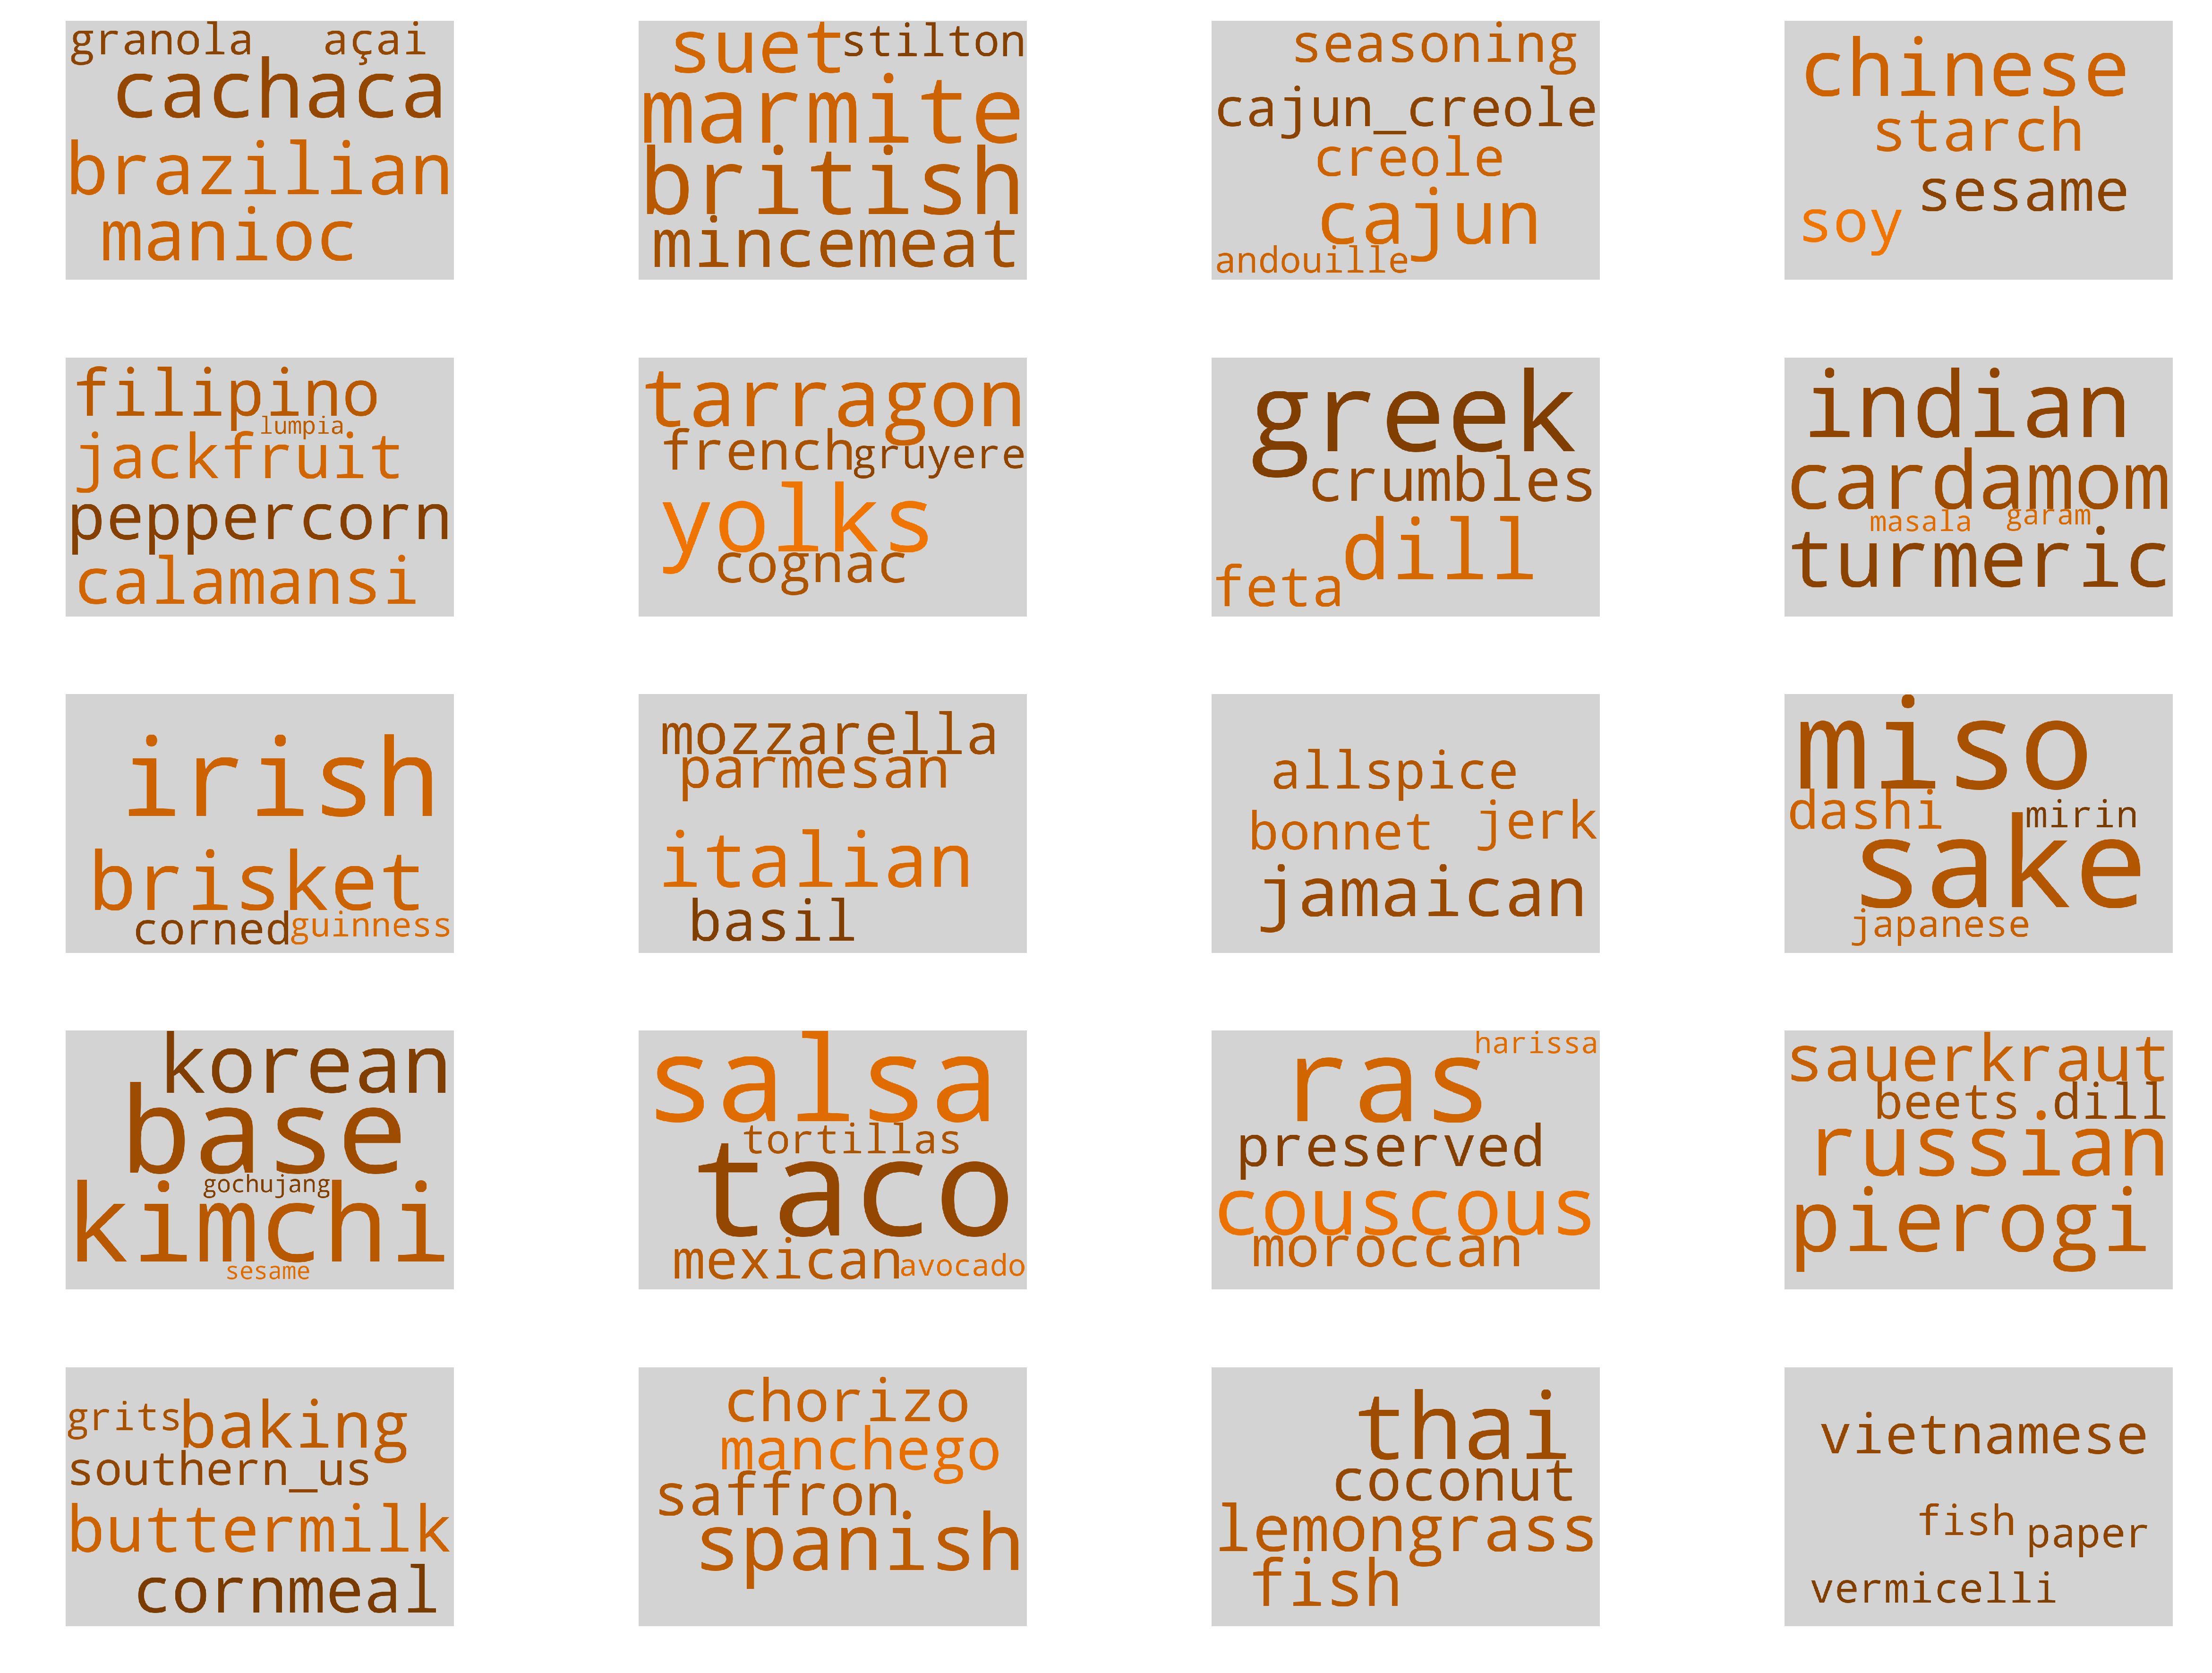

In [348]:
f,axarr = plt.subplots(5, 4, figsize=(20,15), dpi=300)
wordcloud = []
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 21.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

for i in range(len(com_unigram_list)):
    wordcloud.append(WordCloud(background_color='lightgrey',
                      width=1200,
                      height=800,
                color_func=random_color_func
                     ).generate(cuisine_list[i] +' ' + ' '.join(com_unigram_list[i])))
                               
    axarr[int(i/4), int(i%4)].imshow(wordcloud[i])
    axarr[int(i/4), int(i%4)].axis('off')

# Fine-tune figure; make subplots farther from each other.
f.subplots_adjust(hspace=0.3)
f.savefig('title.png')
plt.show()

In [200]:
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['ingredients2'], df['cuisine_id'], random_state = 0)
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()


(29830, 1)

In [205]:
from sklearn.model_selection import KFold
ntrain = X_train.shape[0]
ntest = X_test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits= NFOLDS)

def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    i=0
    for train_index, val_index in kf.split(x_train):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index].ravel()
        x_val = x_train[val_index]

        clf.fit(x_tr, y_tr)

        oof_train[val_index] = clf.predict(x_val)
        oof_test_skf[i, :] = clf.predict(x_test)
        i+=1

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [245]:
nb = MultinomialNB()
nb_oof_train, nb_oof_test = get_oof(nb, X_train_tfidf, y_train.ravel(), X_test_tfidf)

In [246]:
from sklearn.svm import LinearSVC
svc = LinearSVC()
svc_oof_train, svc_oof_test = get_oof(svc, X_train_tfidf, y_train.ravel(), X_test_tfidf)

In [211]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(random_state=0)
lg_oof_train, lg_oof_test = get_oof(lg, X_train_tfidf, y_train.ravel(), X_test_tfidf)


In [217]:
x_train = np.concatenate(( nb_oof_train, svc_oof_train, lg_oof_train), axis=1)
x_test = np.concatenate(( nb_oof_test, svc_oof_test, lg_oof_test), axis=1)

In [238]:
base_predictions_train = pd.DataFrame( {'naive bayes': nb_oof_train.ravel(),
     'svc': svc_oof_train.ravel(),
     'logisic': lg_oof_train.ravel(),
    })
base_predictions_train.head()

,logisic,naive bayes,svc
0,6.0,6.0,6.0
1,7.0,7.0,7.0
2,7.0,7.0,7.0
3,14.0,14.0,14.0
4,6.0,6.0,6.0


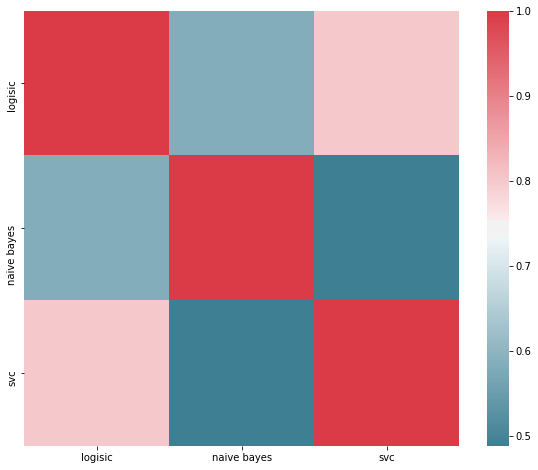

In [243]:
import seaborn as sns
corr = base_predictions_train.corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

In [247]:
import xgboost as xgb
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train.ravel())
predictions = gbm.predict(x_test)

/Users/yinglirao/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


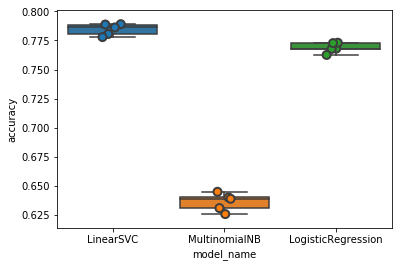

In [263]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [349]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

TypeError: 'Figure' object is not iterable

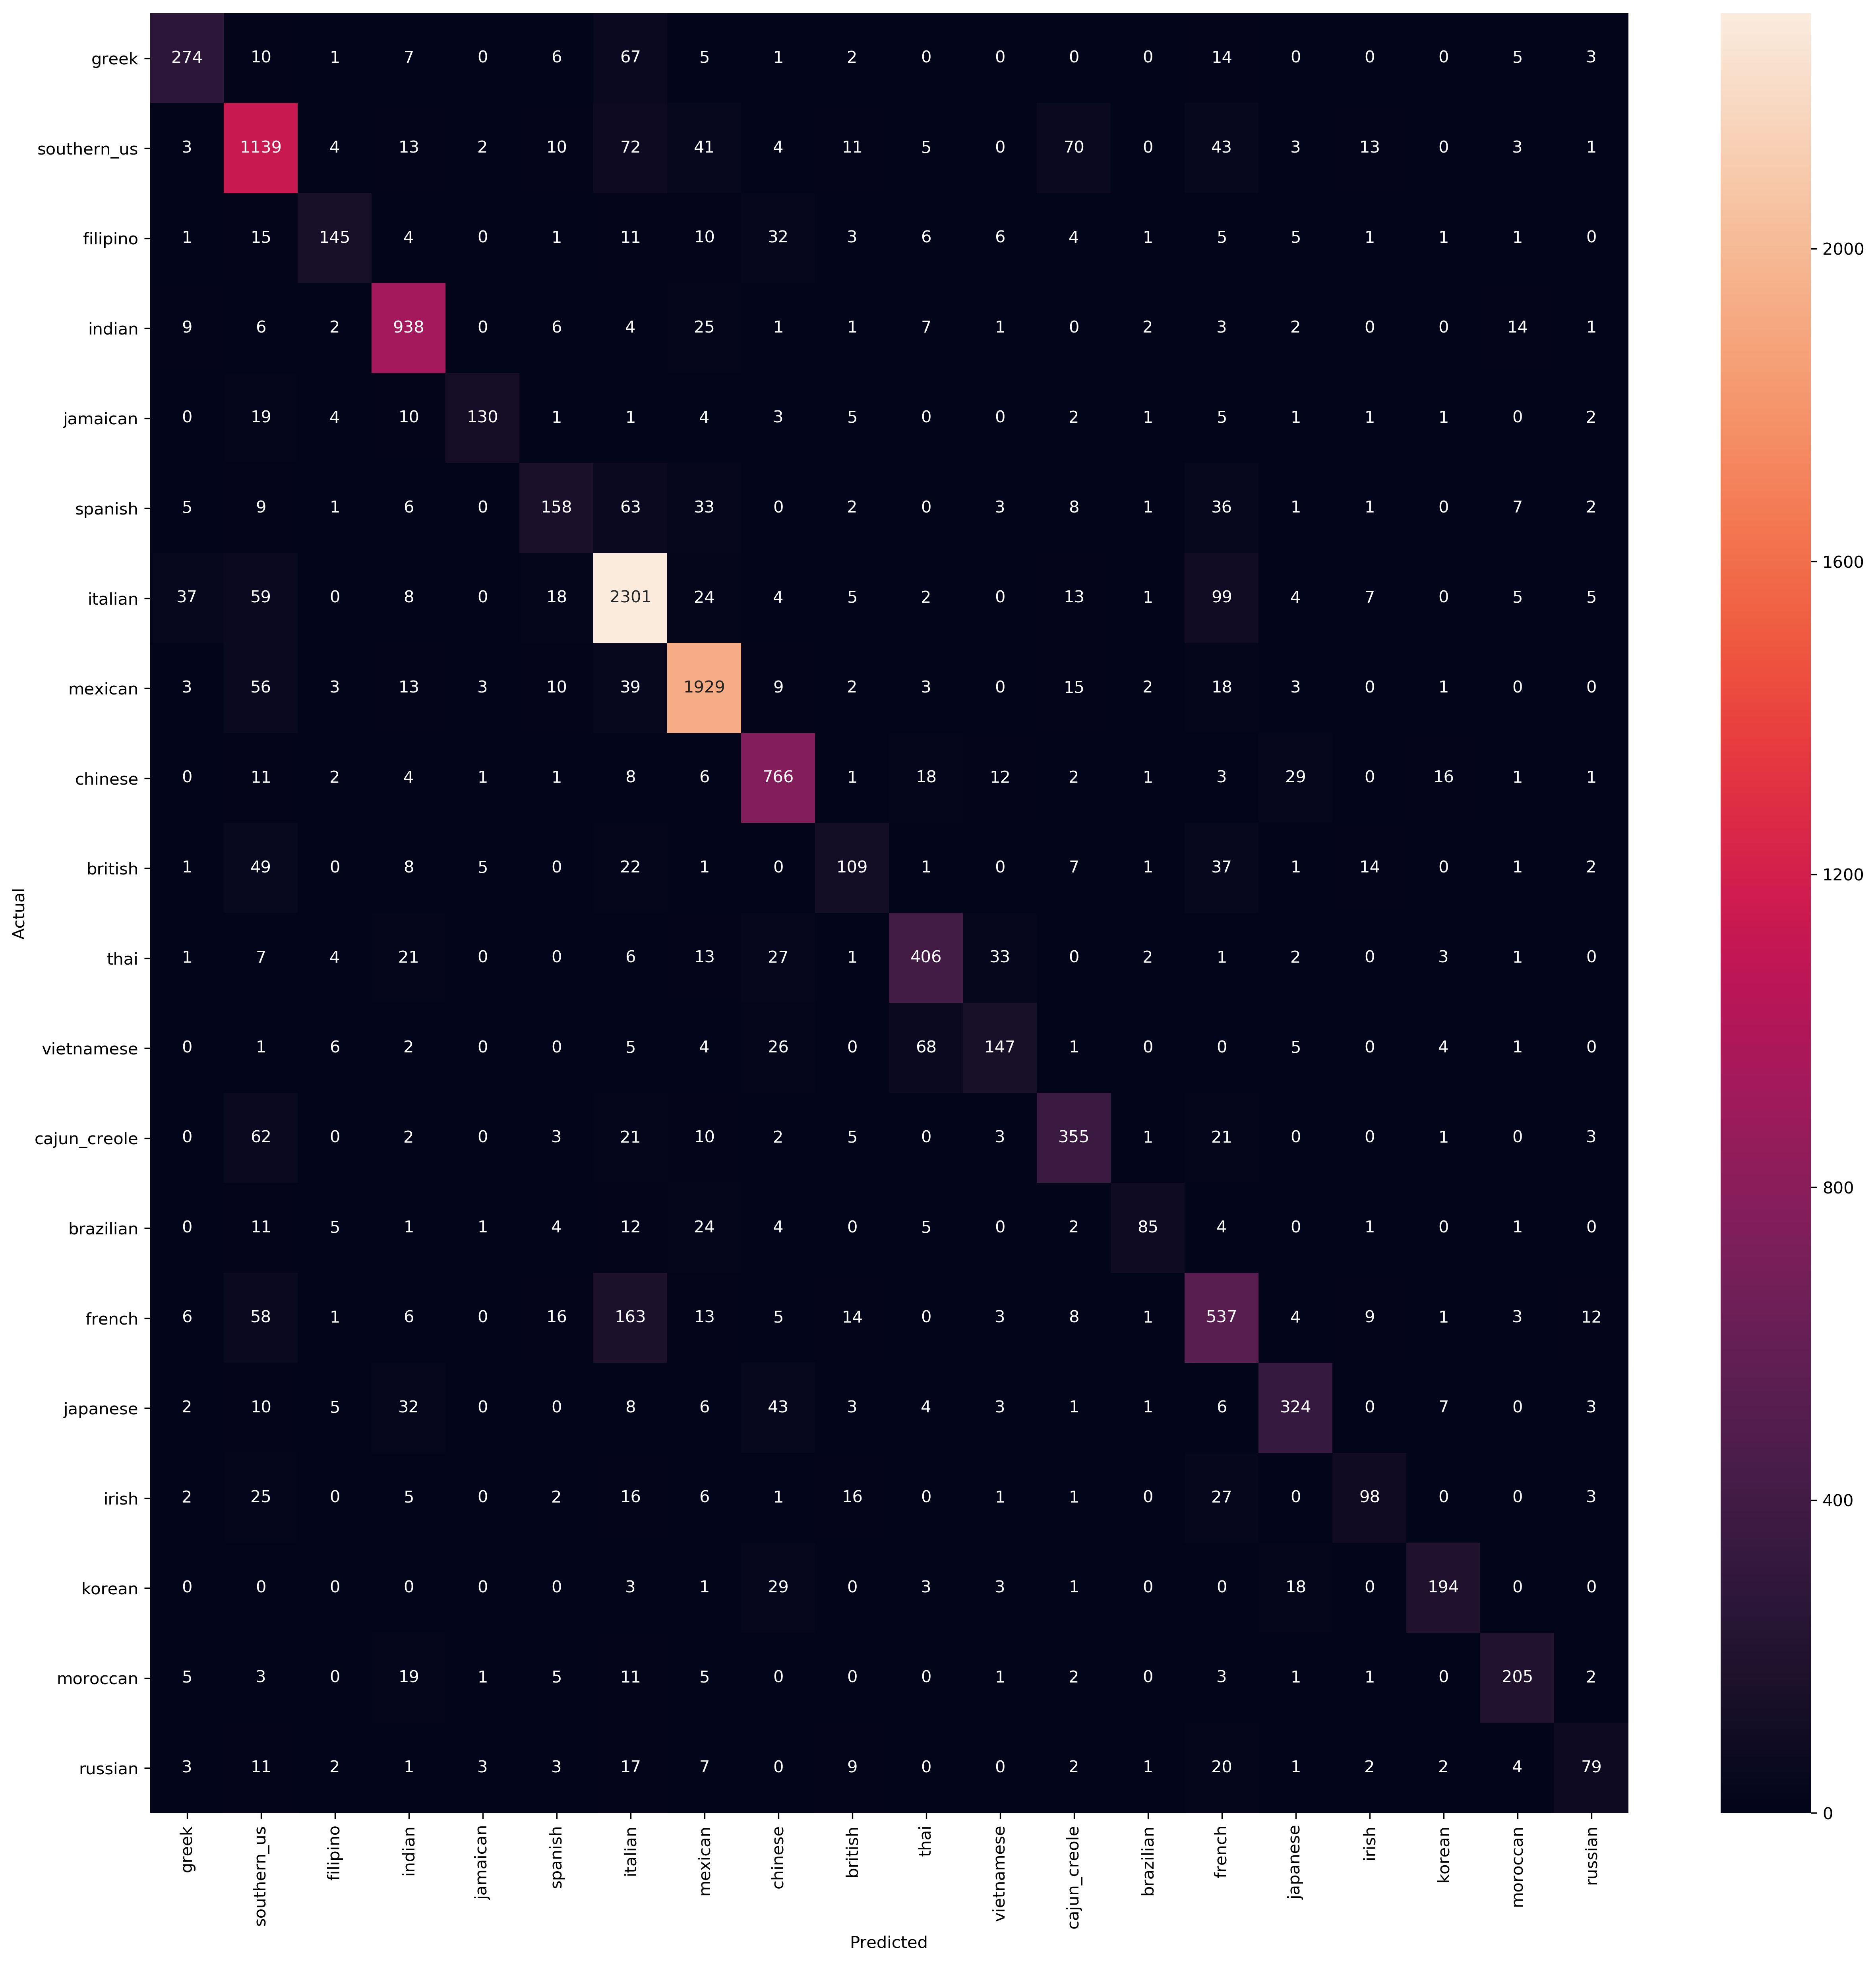

In [351]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(20,20), dpi=300)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=cuisine_id_df.cuisine.values, yticklabels=cuisine_id_df.cuisine.values)

ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
fig.savefig('confusion_matrix.png')
plt.show()

In [270]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['cuisine'].unique()))

              precision    recall  f1-score   support

       greek       0.78      0.69      0.73       395
 southern_us       0.73      0.79      0.76      1437
    filipino       0.78      0.58      0.66       252
      indian       0.85      0.92      0.88      1022
    jamaican       0.89      0.68      0.77       190
     spanish       0.65      0.47      0.54       336
     italian       0.81      0.89      0.85      2592
     mexican       0.89      0.91      0.90      2109
     chinese       0.80      0.87      0.83       883
     british       0.58      0.42      0.49       259
        thai       0.77      0.77      0.77       528
  vietnamese       0.68      0.54      0.60       270
cajun_creole       0.72      0.73      0.72       489
   brazilian       0.84      0.53      0.65       160
      french       0.61      0.62      0.62       860
    japanese       0.80      0.71      0.75       458
       irish       0.66      0.48      0.56       203
      korean       0.84    